In [1]:
import datetime
import tweepy

from time import sleep

from API_keys import api_key, api_key_secret, access_token, access_token_secret

In [2]:
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [28]:
import pandas as pd
import numpy as np
from string import punctuation
punctuation = set(punctuation)
punctuation.remove(',')
import nltk
import spacy
import locationtagger
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
import nltk
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from string import punctuation
punctuation = set(punctuation)

In [ ]:
#nltk.downloader.download('maxent_ne_chunker')
#nltk.downloader.download('words')
#nltk.downloader.download('treebank')
#nltk.downloader.download('maxent_treebank_pos_tagger')
#nltk.downloader.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [ ]:
# I'm putting the handles in a list to iterate through below
band_handles = ['thursdayband', 'circasurvive', 'MCRofficial', 'Coheed']


# This will iterate through each Twitter handle that we're collecting from
for screen_name in band_handles:
    
    # Tells Tweepy we want information on the handle we're collecting from
    # The next line specifies which information we want, which in this case is the number of followers 
    user = api.get_user(screen_name=screen_name) 
    followers_count = user.followers_count

    # Let's see roughly how long it will take to grab all the follower IDs. 
    print(f'''
    @{screen_name} has {followers_count} followers. 
    That will take roughly {followers_count/(5000*60):.0f} hours and {followers_count/(5000):.2f} minutes
    ''')
    

In [ ]:
id_dict = {'thursdayband' : []
          'circasurvive' : [],
          'MCRofficial' : [],
          'Coheed' : []}

start_time = datetime.datetime.now()

for handle in id_dict.keys():

    for page in tweepy.Cursor(api.get_follower_ids,
                              compression = True,
                              screen_name=handle).pages():
        
        id_dict[handle].extend(page)
        
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(elapsed_time)

In [ ]:
def get_screen_names(list_of_ids, list_for_screen_names):
    start=0 #we have feed the API 100 ID's at a time, this will iterate through them
    end=0
    followers=[]
    while end-1 <= len(list_of_ids): #quit when we get past the end of our list
        end += 100 #update the end of our slice
        if end <= len(list_of_ids): #split into if else statement to slice correctly
            try:
                followers_temp = api.lookup_users(user_id = list_of_ids[start:end])  
            except tweepy.TweepError as err:
                if err.code == 103:
                    print('sleeping, 900 seconds')
                    time.sleep(900)
        else:
            try:
                followers_temp = api.lookup_users(user_id = list_of_ids[start:])   
            except tweepy.TweepError as err:
                if err.code == 103:
                    print('sleeping, 900 seconds')
                    time.sleep(900)
        followers.extend(followers_temp)
        start = end #update our starting slice index for next loop
    list_for_screen_names.extend(followers)

In [ ]:
user_dict = {'thursdayband': []
            'circasurvive' : [],
            'MCRofficial' : [],
            'Coheed' : []}


for handle in user_dict:
    get_screen_names(id_dict[handle], user_dict[handle])

In [ ]:
headers = ['screen_name', 'description', 'location', 'follower_count']

for band in user_dict.keys():

    with open(f'{band}_followers_new.txt','w', encoding='utf-8') as out_file:
        out_file.write('\t'.join(headers) + '\n')

        for idx, user in enumerate(user_dict[band]):
            description = str(user.description).replace('\t',' ').replace('\n',' ').replace('\r',' ')
            followers_count = user.followers_count
            outline = [user.screen_name, description, user.location, followers_count]

            out_file.write('\t'.join([str(item) for item in outline]) + '\n')
    
            

### Finding Locations

In [ ]:
for band in user_dict.keys():

    with open(f'{band}_followers_descriptions.txt','w', encoding='utf-8') as out_file:
        headers = ['screen_name', 'description']
        out_file.write('\t'.join(headers) + '\n')

        for idx, user in enumerate(user_dict[band]):
            description = str(user.description).replace('\t',' ').replace('\n',' ').replace('\r',' ')
            outline = [user.screen_name, description]
            
            out_file.write('\t'.join([str(item) for item in outline]) + '\n')           

    with open(f'{band}_followers_locations.txt','w', encoding='utf-8') as out_file:
        headers = ['screen_name', 'location'] 
        out_file.write('\t'.join(headers) + '\n')
        
        for idx, user in enumerate(user_dict[band]):
            location = user.location
            outline = [user.screen_name, location]
            
            out_file.write('\t'.join([str(item) for item in outline]) + '\n')

In [ ]:
# The data took about 12 hours to pull in. It was written out to serve as a checkpoint


thursday_locations_df = pd.read_csv('thursdayband_followers_locations.txt', sep = '\t',
                           on_bad_lines = 'skip', keep_default_na = False)

circa_survive_locations_df = pd.read_csv('circasurvive_followers_locations.txt', sep = '\t',
                           on_bad_lines = 'skip', keep_default_na = False)

mcr_locations_df = pd.read_csv('MCRofficial_followers_locations.txt', sep = '\t',
                           on_bad_lines = 'skip', keep_default_na = False)

coheed_locations_df = pd.read_csv('Coheed_followers_locations.txt', sep = '\t',
                           on_bad_lines = 'skip', keep_default_na = False)

thursday_locations = [loc.lower() for loc in thursday_locations_df['location'] if loc != '']

circa_locations = [loc.lower() for loc in circa_survive_locations_df['location'] if loc != '']

mcr_locations = [loc.lower() for loc in mcr_locations_df['location'] if loc != '']

coheed_locations = [loc.lower() for loc in coheed_locations_df['location'] if loc != '']

In [ ]:
def get_locations(input_locations, output_locations):
    for ind, loc in enumerate(input_locations):
        place_entity = locationtagger.find_locations(text = loc)
    
        if place_entity.countries or place_entity.cities or place_entity.regions:
            output_locations.append(loc.lower())
        else:
            pass
        
        if ind % 100 == 0:
            print(ind)

In [ ]:
thursday_locations_update = []
coheed_locations_update = []
circa_locations_update = []
mcr_locations_update = []

get_locations(thursday_locations, thursday_locations_update)
print('Done with Thursday')

get_locations(circa_locations, circa_locations_update)
print('Done with Circa Survive')

get_locations(coheed_locations, coheed_locations_update)
print('Done with Coheed and Cambria')

get_locations(mcr_locations, mcr_locations_update)
print('Moving to next band')

# Calling in lists of locations

In [ ]:
thursday_locations_df = pd.DataFrame(thursday_locations_update, columns = 'Locations')
circa_locations_df = pd.DataFrame(circa_locations_update, columns = 'Locations')
coheed_locations_df = pd.DataFrame(coheed_locations_update, columns = 'Locations')
mcr_locations_df =pd.DataFrame(mcr_locations_update, columns = 'Locations')

In [ ]:
#Another checkpoint

#thursday_locations_df.to_csv('thursday_locations.csv')
#circa_locations_df.to_csv('circa_locations.csv')
#coheed_locations_df.to_csv('coheed_locations.csv')
#mcr_locations_df.to_csv('mcr_locations.csv')

In [7]:
thursday_locations_df = pd.read_csv('thursday_locations.csv')
circa_locations_df = pd.read_csv('circa_locations.csv')
coheed_locations_df = pd.read_csv('coheed_locations.csv')
mcr_locations_df = pd.read_csv('mcr_locations.csv')

In [11]:
thursday_locations = thursday_locations_df['0'].tolist()
circa_locations = circa_locations_df['0'].tolist()
coheed_locations = coheed_locations_df['0'].tolist()
mcr_locations = mcr_locations_df['0'].tolist()

In [12]:
total_locations = []
for i in thursday_locations:
    total_locations.append(i)
for i in circa_locations:
    total_locations.append(i)
for i in coheed_locations:
    total_locations.append(i)
for i in mcr_locations:
    total_locations.append(i)

In [ ]:
state_abbrevs = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT',
               'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS',
               'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT',
                'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR',
                'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
                'WA', 'WV', 'WI', 'WY']

In [ ]:
thursday_loc_dict = {'cities': [],
                'states' : [], 
                'countries' : []}
    
circa_loc_dict = {'cities': [],
                     'states' : [], 
                     'countries' : []}
    
mcr_loc_dict = {'cities': [],
                'states' : [],
                'countries' : []}
    
coheed_loc_dict = {'cities': [],
                      'states' : [], 
                      'countries' : []}

In [ ]:
def get_band_location_dict(band_locations, band_dict):
    
    for loc in band_locations:
        place_entity = locationtagger.find_locations(text = loc)
        city = place_entity.cities
        country = place_entity.countries
        state = place_entity.regions
        
        if country:
            pass
            #country = "".join([ch for ch in country if ch not in punctuation])
            #band_dict['countries'].extend(country)
            #print('appended ' + str(country) + ' to countries')
        
        if state:
            band_dict['states'].extend(state)
            print('appended ' + str(state) + ' to states')
            continue
              
        if city:
            band_dict['cities'].extend(city)
            print('appended ' + str(city) + ' to cities')
    
        try:
            abbrev =  loc.split(', ', 1)[1]
            abbrev = abbrev.upper()
            if abbrev in state_names:
                band_dict['states'].append(abbrev)
                print('appended ' + str(abbrev) + ' to states' )
        except IndexError:
            pass
        
    
        

In [ ]:
get_band_location_dict(thursday_locations, thursday_loc_dict)

In [ ]:
get_band_location_dict(circa_locations, circa_loc_dict)

In [ ]:
get_band_location_dict(coheed_locations, coheed_loc_dict)

In [ ]:
get_band_location_dict(mcr_locations, mcr_loc_dict)

## Cleaning states, send it to csv/txt

In [ ]:
def clean_states_list(band_states):
    
    state_abbrevs = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT',
               'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS',
               'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT',
                'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR',
                'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
                'WA', 'WV', 'WI', 'WY']
    
    for i in range(len(band_states)):

        if band_states[i] == 'Alabama':
            band_states[i] = 'AL'
        if band_states[i] == 'Alaska':
            band_states[i] = 'AK'
        if band_states[i] == 'Arizona':
            band_states[i] = 'AZ'
        if band_states[i] == 'Arkansas':
            band_states[i] = 'AR'
        if band_states[i] == 'California':
            band_states[i] = 'CA'
        if band_states[i] == 'Colorado':
            band_states[i] = 'CO'
        if band_states[i] == 'Connecticut':
            band_states[i] = 'CT'
        if band_states[i] == 'Delaware':
            band_states[i] = 'DE'
        if band_states[i] == 'Florida':
            band_states[i] = 'FL'
        if band_states[i] == 'Georgia':
            band_states[i] = 'GA'
        if band_states[i] == 'Hawaii':
            band_states[i] = 'HI'
        if band_states[i] == 'Idaho':
            band_states[i] = 'ID'
        if band_states[i] == 'Illinois':
            band_states[i] = 'IL'
        if band_states[i] == 'Indiana':
            band_states[i] = 'IN'
        if band_states[i] == 'Iowa':
            band_states[i] = 'IA'
        if band_states[i] == 'Kansas':
            band_states[i] = 'KS'
        if band_states[i] == 'Kentucky':
            band_states[i] = 'KY'
        if band_states[i] == 'Louisiana':
            band_states[i] = 'LA'
        if band_states[i] == 'Maine':
            band_states[i] = 'ME'
        if band_states[i] == 'Maryland':
            band_states[i] = 'MD'
        if band_states[i] == 'Massachusetts':
            band_states[i] = 'MA'
        if band_states[i] == 'Michigan':
            band_states[i] = 'MI'
        if band_states[i] == 'Minnesota':
            band_states[i] = 'MN'
        if band_states[i] == 'Mississippi':
            band_states[i] = 'MS'
        if band_states[i] == 'Missouri':
            band_states[i] = 'MO'
        if band_states[i] == 'Montana':
            band_states[i] = 'MT'
        if band_states[i] == 'Nebraska':
            band_states[i] = 'NE'
        if band_states[i] == 'Nevada':
            band_states[i] = 'NV'
        if band_states[i] == 'New Hampshire':
            band_states[i] = 'NH'
        if band_states[i] == 'New Jersey':
            band_states[i] = 'NJ'
        if band_states[i] == 'New Mexico':
            band_states[i] = 'NM'
        if band_states[i] == 'New York':
            band_states[i] = 'NY'
        if band_states[i] == 'North Carolina':
            band_states[i] = 'NC'
        if band_states[i] == 'North Dakota':
            band_states[i] = 'ND'
        if band_states[i] == 'Ohio':
            band_states[i] = 'OH'
        if band_states[i] == 'Oklahoma':
            band_states[i] = 'OK'
        if band_states[i] == 'Oregon':
            band_states[i] = 'OR'
        if band_states[i] == 'Pennsylvania':
            band_states[i] = 'PA'
        if band_states[i] == 'Rhode Island':
            band_states[i] = 'RI'
        if band_states[i] == 'South Carolina':
            band_states[i] = 'SC'
        if band_states[i] == 'South Dakota':
            band_states[i] = 'SD'
        if band_states[i] == 'Tennessee':
            band_states[i] = 'TN'
        if band_states[i] == 'Texas':
            band_states[i] = 'TX'
        if band_states[i] == 'Utah':
            band_states[i] = 'UT'
        if band_states[i] == 'Vermont':
            band_states[i] = 'VT'
        if band_states[i] == 'Virginia':
            band_states[i] = 'VA'
        if band_states[i] == 'Washington':
            band_states[i] = 'WA'
        if band_states[i] == 'West Virginia':
            band_states[i] = 'WV'
        if band_states[i] == 'Wisconsin':
            band_states[i] = 'WI'
        if band_states[i] == 'Wyoming':
            band_states[i] = 'WY'
        
        if band_states[i] not in state_abbrevs:
            pass

In [ ]:
thursday_states = thursday_loc_dict['states']
circa_states = circa_loc_dict['states']
coheed_states = coheed_loc_dict['states']
mcr_states = mcr_loc_dict['states']
#mcr_states = pd.read_csv('mcr_states.txt', sep="\t", header=None)
#mcr_states = mcr_states[0].to_list()


clean_states_list(thursday_states)
clean_states_list(circa_states)
clean_states_list(coheed_states)
clean_states_list(mcr_states)

In [ ]:
total_states = []
for i in circa_states:
    total_states.append(i)

for i in coheed_states:
    total_states.append(i)
    
for i in mcr_states:
    total_states.append(i)
    
for i in thursday_states:
    total_states.append(i)

In [ ]:
thursday_states_df = pd.DataFrame(thursday_states)
circa_states_df = pd.DataFrame(circa_states)
coheed_states_df = pd.DataFrame(coheed_states)
mcr_states_df = pd.DataFrame(mcr_states)

In [ ]:
#States written to txt/csv to transfer over to R for Indexing

thursday_states_df.to_csv('thursday_states.csv')
circa_states_df.to_csv('circa_states.csv')
coheed_states_df.to_csv('coheed_states.csv')
mcr_states_df.to_csv('mcr_states.csv')

textfile = open("thursday_states.txt", "w", encoding = 'utf-8')
for element in thursday_states:
    textfile.write(element + "\n")
textfile.close()


textfile = open("circa_states.txt", "w", encoding = 'utf-8')
for element in circa_states:
    textfile.write(element + "\n")
textfile.close()

textfile = open("coheed_states.txt", "w", encoding = 'utf-8')
for element in coheed_states:
    textfile.write(element + "\n")
textfile.close()

textfile = open("mcr_states_clean.txt", "w", encoding = 'utf-8')
for element in mcr_states:
    textfile.write(element + "\n")
textfile.close()

In [ ]:
#mcr_states_df = pd.DataFrame(mcr_loc_dict['states'])
#mcr_states_df = mcr_states_df.rename(columns = {"0":"Locations"})
#mcr_states = mcr_states_df[0].to_list()
#mcr_states_df.to_csv('mcr_states.csv')

#textfile = open("mcr_states.txt", "w", encoding = 'utf-8')
#for element in mcr_states:
#    textfile.write(element + "\n")
#textfile.close()

### Data was transferred over to R and saved to a txt file

In [ ]:
locations_count_table = pd.read_csv('locations_counts.txt', sep = '\t')

In [ ]:
locations_count_table = locations_count_table.rename(columns={"locations": "State"}) 

In [ ]:
states_cnt_df = locations_count_table[locations_count_table['State'].map(len) == 2]

In [ ]:
states_cnt_df['Total'] = states_cnt_df.sum(axis=1)

In [ ]:
states_index_table = pd.DataFrame()
states_index_table['State'] = states_cnt_df['State']
states_index_table['Thursday'] = states_cnt_df['thursday']/len(thursday_states)
states_index_table['Circa Survive'] = states_cnt_df['circa']/len(circa_states)
states_index_table['Coheed and Cambria'] = states_cnt_df['coheed']/len(coheed_states)
states_index_table['My Chemical Romance'] = states_cnt_df['mcr']/len(mcr_states)
states_index_table['Total'] = states_cnt_df['Total'].apply(lambda x: x/len(total_states))

In [ ]:
states_cnt_df = states_cnt_df.set_index('State')

In [ ]:
states_index_table = states_index_table.set_index('State')

In [ ]:
states_index_table

In [ ]:
thursday_top_10 = states_index_table.sort_values(by = 'Thursday', ascending = False)
thursday_top_10 = thursday_top_10.head(10)

In [ ]:
states_cnt_df.to_csv('state_counts_table.csv')

In [ ]:
us_states = ['alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut',
             'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky',
             'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri',
             'montana', 'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina',
             'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'south dakota',
             'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming',
            'usa', 'england']

In [ ]:
# I was going to do something with the cities but decided not to, and also didnt want to delete the code

#fd_thursday_cities = FreqDist([w.lower() for w in thursday_cities
#                     if w.lower() not in us_states])

fd_thursday_states = FreqDist([w.lower() for w in thursday_states])

#fd_thursday_countries = FreqDist([w.lower() for w in thursday_countries
#                        if w.lower != 'united states'])



#fd_circa_cities = FreqDist([w.lower() for w in circa_cities
#                     if w.lower() not in us_states])

fd_circa_states = FreqDist([w.lower() for w in circa_states])

#fd_circa_countries = FreqDist([w.lower() for w in circa_countries
#                        if w.lower != 'united states'])



#fd_coheed_cities = FreqDist([w.lower() for w in coheed_cities
#                     if w.lower() not in us_states])

fd_coheed_states = FreqDist([w.lower() for w in coheed_states])

#fd_coheed_countries = FreqDist([w.lower() for w in coheed_countries
#                        if w.lower != 'united states'])

#fd_mcr_cities = FreqDist([w.lower() for w in mcr_cities
#                     if w.lower() not in us_states])

fd_mcr_states = FreqDist([w.lower() for w in mcr_states])

#fd_mcr_countries = FreqDist([w.lower() for w in mcr_countries
#                        if w.lower != 'united states'])


### Extracting Gender

In [ ]:
#Reimported because some punctuation marks were deleted
from string import punctuation
punctuation = set(punctuation)

In [5]:
thursday_descriptions_df = pd.read_csv('thursdayband_followers_descriptions.txt', sep = '\t',
                              on_bad_lines = 'skip', keep_default_na = False)

circa_survive_descriptions_df = pd.read_csv('circasurvive_followers_descriptions.txt', sep = '\t',
                              on_bad_lines = 'skip', keep_default_na = False)

mcr_descriptions_df = pd.read_csv('MCRofficial_followers_descriptions.txt', sep = '\t',
                              on_bad_lines = 'skip', keep_default_na = False)

coheed_descriptions_df = pd.read_csv('coheed_followers_descriptions.txt', sep = '\t',
                              on_bad_lines = 'skip', keep_default_na = False)

thursday_descriptions = [desc for desc in thursday_descriptions_df['description'] if desc != '']

circa_descriptions = [desc for desc in circa_survive_descriptions_df['location'] if desc != '']

mcr_descriptions = [desc for desc in mcr_descriptions_df['location'] if desc != '']

coheed_descriptions = [desc for desc in coheed_descriptions_df['location'] if desc != '']

In [6]:
thursday_descriptions_list = []
circa_descriptions_list = []
coheed_descriptions_list = []
mcr_descriptions_list = []

for text in thursday_descriptions:
    thursday_descriptions_list.append(text)
    
for text in circa_descriptions:
    circa_descriptions_list.append(text)
    
for text in coheed_descriptions:
    coheed_descriptions_list.append(text)
    
for text in mcr_descriptions:
    mcr_descriptions_list.append(text)

In [7]:
gender_pronouns = ['he', 'him', 'his', 'husband', 'boyfriend', 'guy', 'he/him', 'he/him/his','father',
                  'she', 'her', 'hers', 'wife', 'girl', 'girlfriend', 'she/her', 'she/her/hers', 'mother',
                  'they', 'them', 'theirs', 'they/them', 'they/them/theirs',
                  'ze', 'hir', 'zir', 'hirs', 'zirs',
                  'he/she/they', 'they/she', 'she/they', 'she/them', 'he/they', 'they/he' 'he/them']

In [8]:
# This was removed because we want to keep combinations of pronouns like he/his
punctuation.remove('/')

In [9]:
gender_pronoun_counter_thursday = []
gender_pronoun_counter_circa = []
gender_pronoun_counter_coheed = []
gender_pronoun_counter_mcr = []

In [40]:
#for description in total_descriptions_list:
#    description_lc = description.lower()
#    description_punc = "".join([ch for ch in description_lc if ch not in punctuation])
#    text_tokenize = word_tokenize(description_punc)
    
#    for w in text_tokenize:
#        if w in gender_pronouns:
#            gender_pronoun_counter_total.append(w)
#        else:
#            pass

In [11]:
def get_description(descriptions_list, pronoun_counter_target):
    
    
    for description in descriptions_list:
        description_lc = description.lower()
        description_punc = "".join([ch for ch in description_lc if ch not in punctuation])
        text_tokenize = word_tokenize(description_punc)
    
        for w in text_tokenize:
            if w in gender_pronouns:
                pronoun_counter_target.append(w)
            else:
                pass

In [12]:
get_description(thursday_descriptions, gender_pronoun_counter_thursday)
get_description(circa_descriptions, gender_pronoun_counter_circa)
get_description(coheed_descriptions, gender_pronoun_counter_coheed)
get_description(mcr_descriptions_list, gender_pronoun_counter_mcr)

In [13]:
pronoun_dict = {'male' : ['he', 'him', 'his', 'husband', 'boyfriend', 'guy', 'he/him', 'he/him/his','father'],
                'female' : ['she', 'her', 'hers', 'wife', 'girl', 'girlfriend', 'she/her', 'she/her/hers', 'mother'],
                'other' : ['ze', 'hir', 'zir', 'hirs', 'zirs', 'he/she/they', 'they/she', 'she/they', 'she/them',
                            'he/they', 'they/he' 'he/them']}

pronoun_counter = {'male' : [],
                  'female' : [],
                  'other' : []}

In [14]:
thursday_male = []
thursday_female = []
thursday_other = []


circa_male = []
circa_female = []
circa_other = []


coheed_male = []
coheed_female = []
coheed_other = []


mcr_male = []
mcr_female = []
mcr_other = []

total_male = []
total_female = []
total_other = []

In [15]:
def sort_gender(band_list_of_pronouns, male, female, other):
    for gender in band_list_of_pronouns:
        if gender in pronoun_dict['male']:
            male.append(gender)
        elif gender in pronoun_dict['female']:
            female.append(gender)
        else:
            other.append(gender) 

In [16]:
sort_gender(gender_pronoun_counter_thursday, thursday_male, thursday_female, thursday_other)
sort_gender(gender_pronoun_counter_coheed, coheed_male, coheed_female, coheed_other)
sort_gender(gender_pronoun_counter_circa, circa_male, circa_female, circa_other)
sort_gender(gender_pronoun_counter_mcr, mcr_male, mcr_female, mcr_other)

In [17]:
for gender in thursday_male:
    total_male.append(gender)
for gender in circa_male:
    total_male.append(gender)
for gender in coheed_male:
    total_male.append(gender)
for gender in mcr_male:
    total_male.append(gender)
    
    
for gender in thursday_female:
    total_female.append(gender)
for gender in circa_female:
    total_female.append(gender)
for gender in coheed_female:
    total_female.append(gender)
for gender in mcr_female:
    total_female.append(gender)
    

for gender in thursday_other:
    total_other.append(gender)
for gender in circa_other:
    total_other.append(gender)
for gender in coheed_other:
    total_other.append(gender)
for gender in mcr_other:
    total_other.append(gender)

In [18]:
total_all = total_male + total_female + total_other

In [107]:
#for gender in total_male:
#    total_male.append(gender)

#for gender in total_female:
#    total_female.append(gender)
    
#for gender in total_other:
#    total_other.append(gender)

In [21]:
total = len(total_male) + len(total_female) + len(total_other) 

In [22]:
data = {'Male': (len(total_male)/total)*100,
       'Female' : (len(total_female)/total) * 100,
       'Other' : (len(total_other)/total) *100}

In [24]:
genders = list(data.keys())
counts = list(data.values())

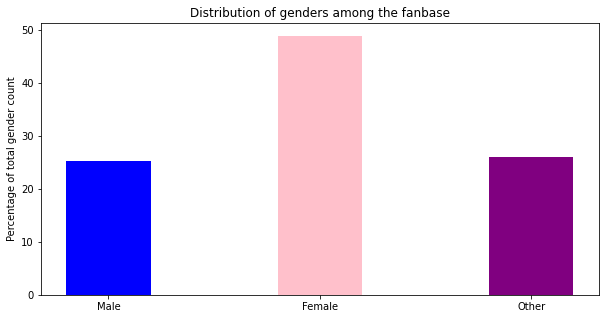

In [25]:
fig = plt.figure(figsize = (10, 5))

my_colors = list(islice(cycle(['blue', 'pink', 'purple']), None, len(genders)))
 
plt.bar(genders, counts, color =my_colors,
        width = 0.4)
 

plt.ylabel("Percentage of total gender count")
plt.title("Distribution of genders among the fanbase")
plt.show()

In [31]:
fd_total_genders = FreqDist([w for w in total_all])

In [32]:
genders = fd_total_genders.keys()
values = fd_total_genders.values()

In [33]:
male_fd = FreqDist([w for w in total_male])
male_label = male_fd.keys()
male_values = male_fd.values()

female_fd = FreqDist([w for w in total_female])
female_label = female_fd.keys()
female_values = female_fd.values()

other_fd = FreqDist([w for w in total_other])
other_label = other_fd.keys()
other_values = other_fd.values()

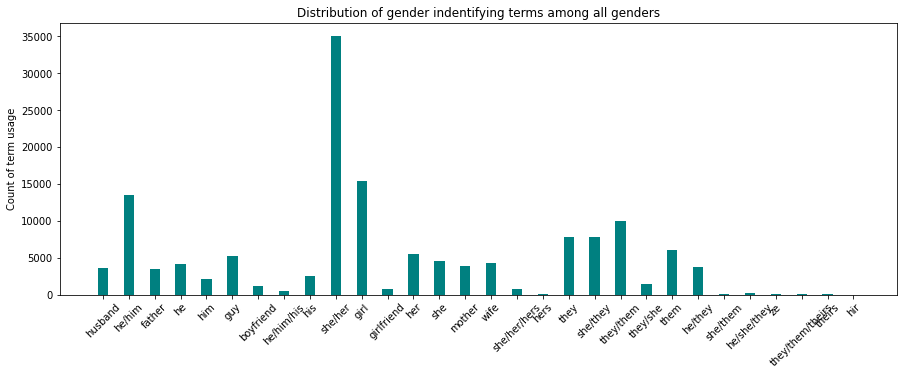

In [34]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(genders, values, color ='teal',
        width = 0.4)
 

plt.ylabel("Count of term usage")
plt.title('Distribution of gender indentifying terms among all genders')
plt.xticks(rotation = 45)
plt.show()

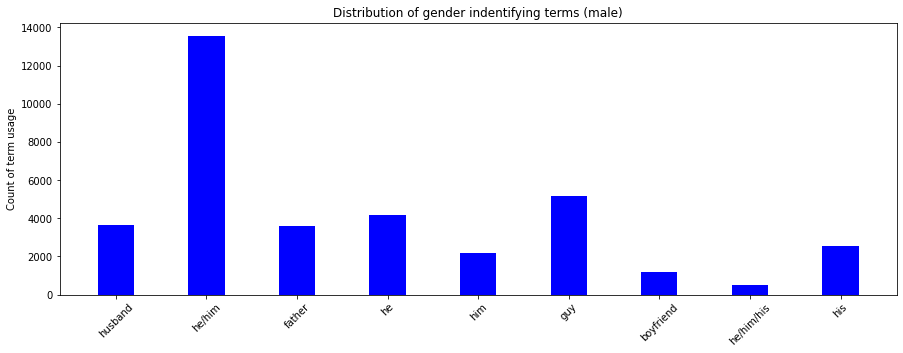

In [61]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(male_label, male_values, color ='blue',
        width = 0.4)
 

plt.ylabel("Count of term usage")
plt.title('Distribution of gender indentifying terms (male)')
plt.xticks(rotation = 45)
plt.show()

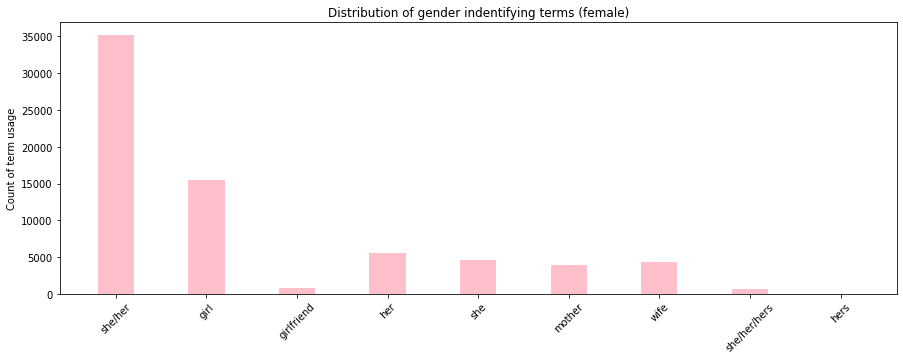

In [60]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(female_label, female_values, color ='pink',
        width = 0.4)
 

plt.ylabel("Count of term usage")
plt.title('Distribution of gender indentifying terms (female)')
plt.xticks(rotation = 45)
plt.show()

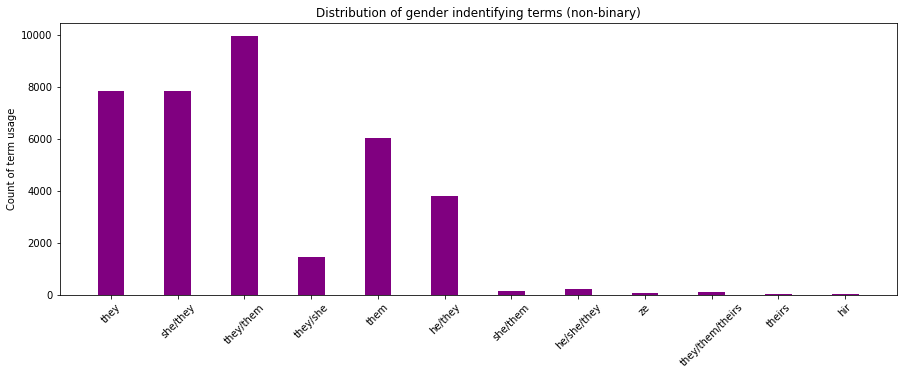

In [59]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(other_label, other_values, color ='purple',
        width = 0.4)
 

plt.ylabel("Count of term usage")
plt.title('Distribution of gender indentifying terms (non-binary)')
plt.xticks(rotation = 45)
plt.show()